# Recurrent Neural Networks
### By: Diego Coello de Portugal Mecke

This notebook aims to experiment with RNN (Recurrent Neural Networks) in the Time Series domain. The dataset used is [PeekDB](https://www.scitepress.org/Papers/2018/65852/65852.pdf), in particular, the data has been obtained from https://github.com/RafaelDrumond/PeekDB. This dataset reports the body position and orientation when doing specific activities (Crouching, Running, Swing, etc.). The architectures used will be [LSTMS and GRU's](https://asset-pdf.scinapse.io/prod/2944851425/2944851425.pdf).

The notebook will: 

 - Normalize the data and write a data generator which outputs data pairs of shape x=(Batchsize,60,20), y=(Batchsize,1). The generator should have an argument "mode" which specifies whether we want train/test. Use Actor 0 and 1 for testing, 2 for val, and actor 3 and onwards for training. Limit the experiment to classes "Crouching", "Running", "Swing".
 - Build a LSTM/GRU architecture to succesfully classify this dataset for the classes "Crouching", "Running" and "Swing". Actor 2 will be used for validation, while actor 3 and onwards will be used for training. Additionaly, early stopping will be used on the validation set.
 - Do some experiments regarding the window size will be done.
 - Do some data augmentation to try to improve the model performance.

In [1]:
import numpy as np
import tensorflow as tf
import os
import ast
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import random
import torch

# Load dataset

In [2]:
path = "PeekDB-master/Motion"

x_dset_train, y_dset_train = [], []
x_dset_test, y_dset_test = [], []
x_dset_valid, y_dset_valid = [], []

y_encoding = {"Crouching":np.array([1,0,0]),\
              "Running":np.array([0,1,0]),\
              "Swing":np.array([0,0,1])}

filenames = os.listdir(path)
for filename in filenames:
    cl = ''.join([i for i in filename.split(".")[0] if not i.isdigit()])
    actor = int(filename[5])
    cl = cl[5:]
    
    if cl in ["Crouching", "Running", "Swing"]:

        file = open(os.path.join(path,filename),"r").read().split("\n")

        data = []
        for line in file:
            if len(line) == 0:
                continue

            ts = line.split("|m")[1].split("|class")[0]

            data.append([float(val) for val in ts.split(" ") if len(val)!=0])

        if actor > 2:
            x_dset_train.append(np.array(data))
            y_dset_train.append(y_encoding[cl])
        elif actor > 1:
            x_dset_valid.append(np.array(data))
            y_dset_valid.append(y_encoding[cl])
        else:
            x_dset_test.append(np.array(data))
            y_dset_test.append(y_encoding[cl])

In [3]:
#Auxiliar function for visualization
def plot_data(data):
    fig = plt.figure(figsize=(20,25))
    gs = grid.GridSpec(5,4)
    d = np.array(data)

    for i in range(5):
        for j in range(4):
            idx = j+i*4
            ax = plt.subplot(gs[i,j])

            ax.plot(d[:,idx])

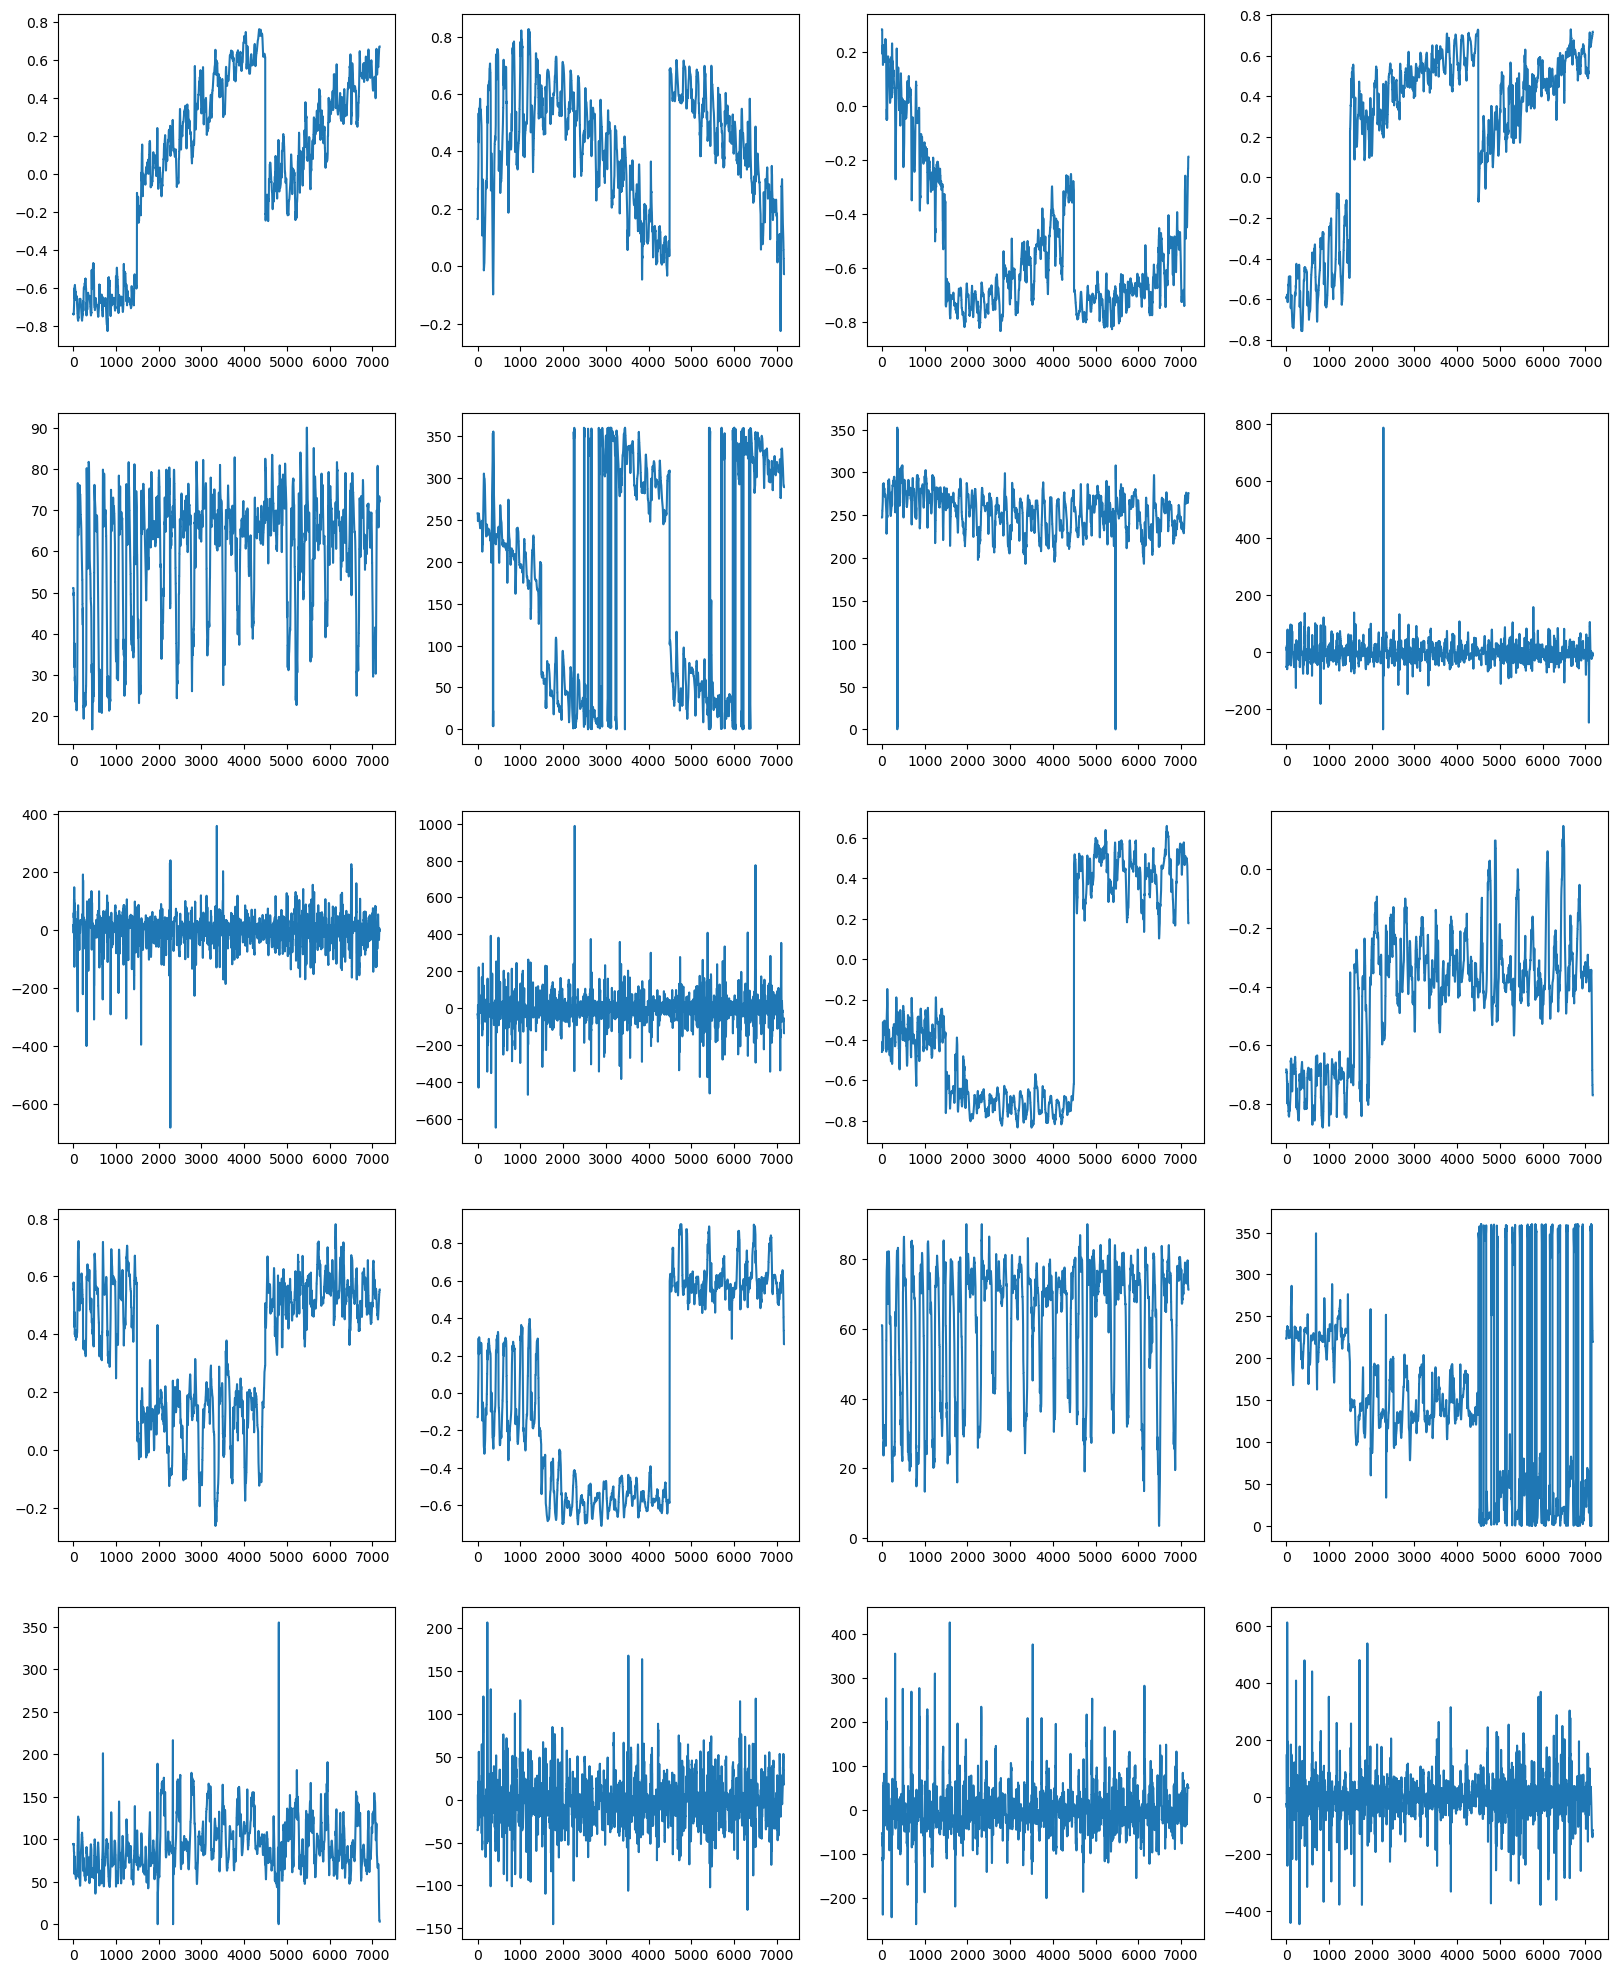

In [4]:
plot_data(x_dset_train[0])

# Dataset Normalization

In [5]:
#Calculate mean and std
total = 0
values = x_dset_train[0]
for x in x_dset_train[1:]:
    values = np.append(values, x, axis=0)
for x in x_dset_test:
    values = np.append(values, x, axis=0)
for x in x_dset_valid:
    values = np.append(values, x, axis=0)

mean = np.mean(np.array(values), axis=0)
std = np.std(np.array(values), axis=0)

print("Mean:\n",mean,"\n\n")
print("STD:\n", std)

#Normalize data by substracting the mean and dividing by std
aux_dset_train = []
aux_dset_test = []
aux_dset_valid = []

for x in x_dset_train:
    aux_dset_train.append((x-mean)/std)
for x in x_dset_test:
    aux_dset_test.append((x-mean)/std)
for x in x_dset_valid:
    aux_dset_valid.append((x-mean)/std)
    
x_dset_train = aux_dset_train
x_dset_test = aux_dset_test
x_dset_valid = aux_dset_valid

Mean:
 [ 2.61355483e-02  2.36498011e-03 -1.90427690e-02  4.58802818e-02
  1.03538202e+02  1.77009010e+02  2.62666962e+02 -7.30329294e+00
 -2.68148213e+00  5.63747607e-01 -5.94584584e-03 -4.78068206e-02
  6.66227100e-02  1.08137494e-02  9.26830412e+01  1.81489995e+02
  9.03258637e+01 -1.86614290e+00  3.17064692e+00 -4.18291818e+00] 


STD:
 [  0.40476586   0.56473518   0.44396704   0.56300604 113.02980378
 107.01383487  92.48601876 112.85370172 158.33377491 126.62661065
   0.42538564   0.56330378   0.42147571   0.56322093 107.59468438
 102.66657733  82.03442145 100.62507642 138.93053183 111.12890103]


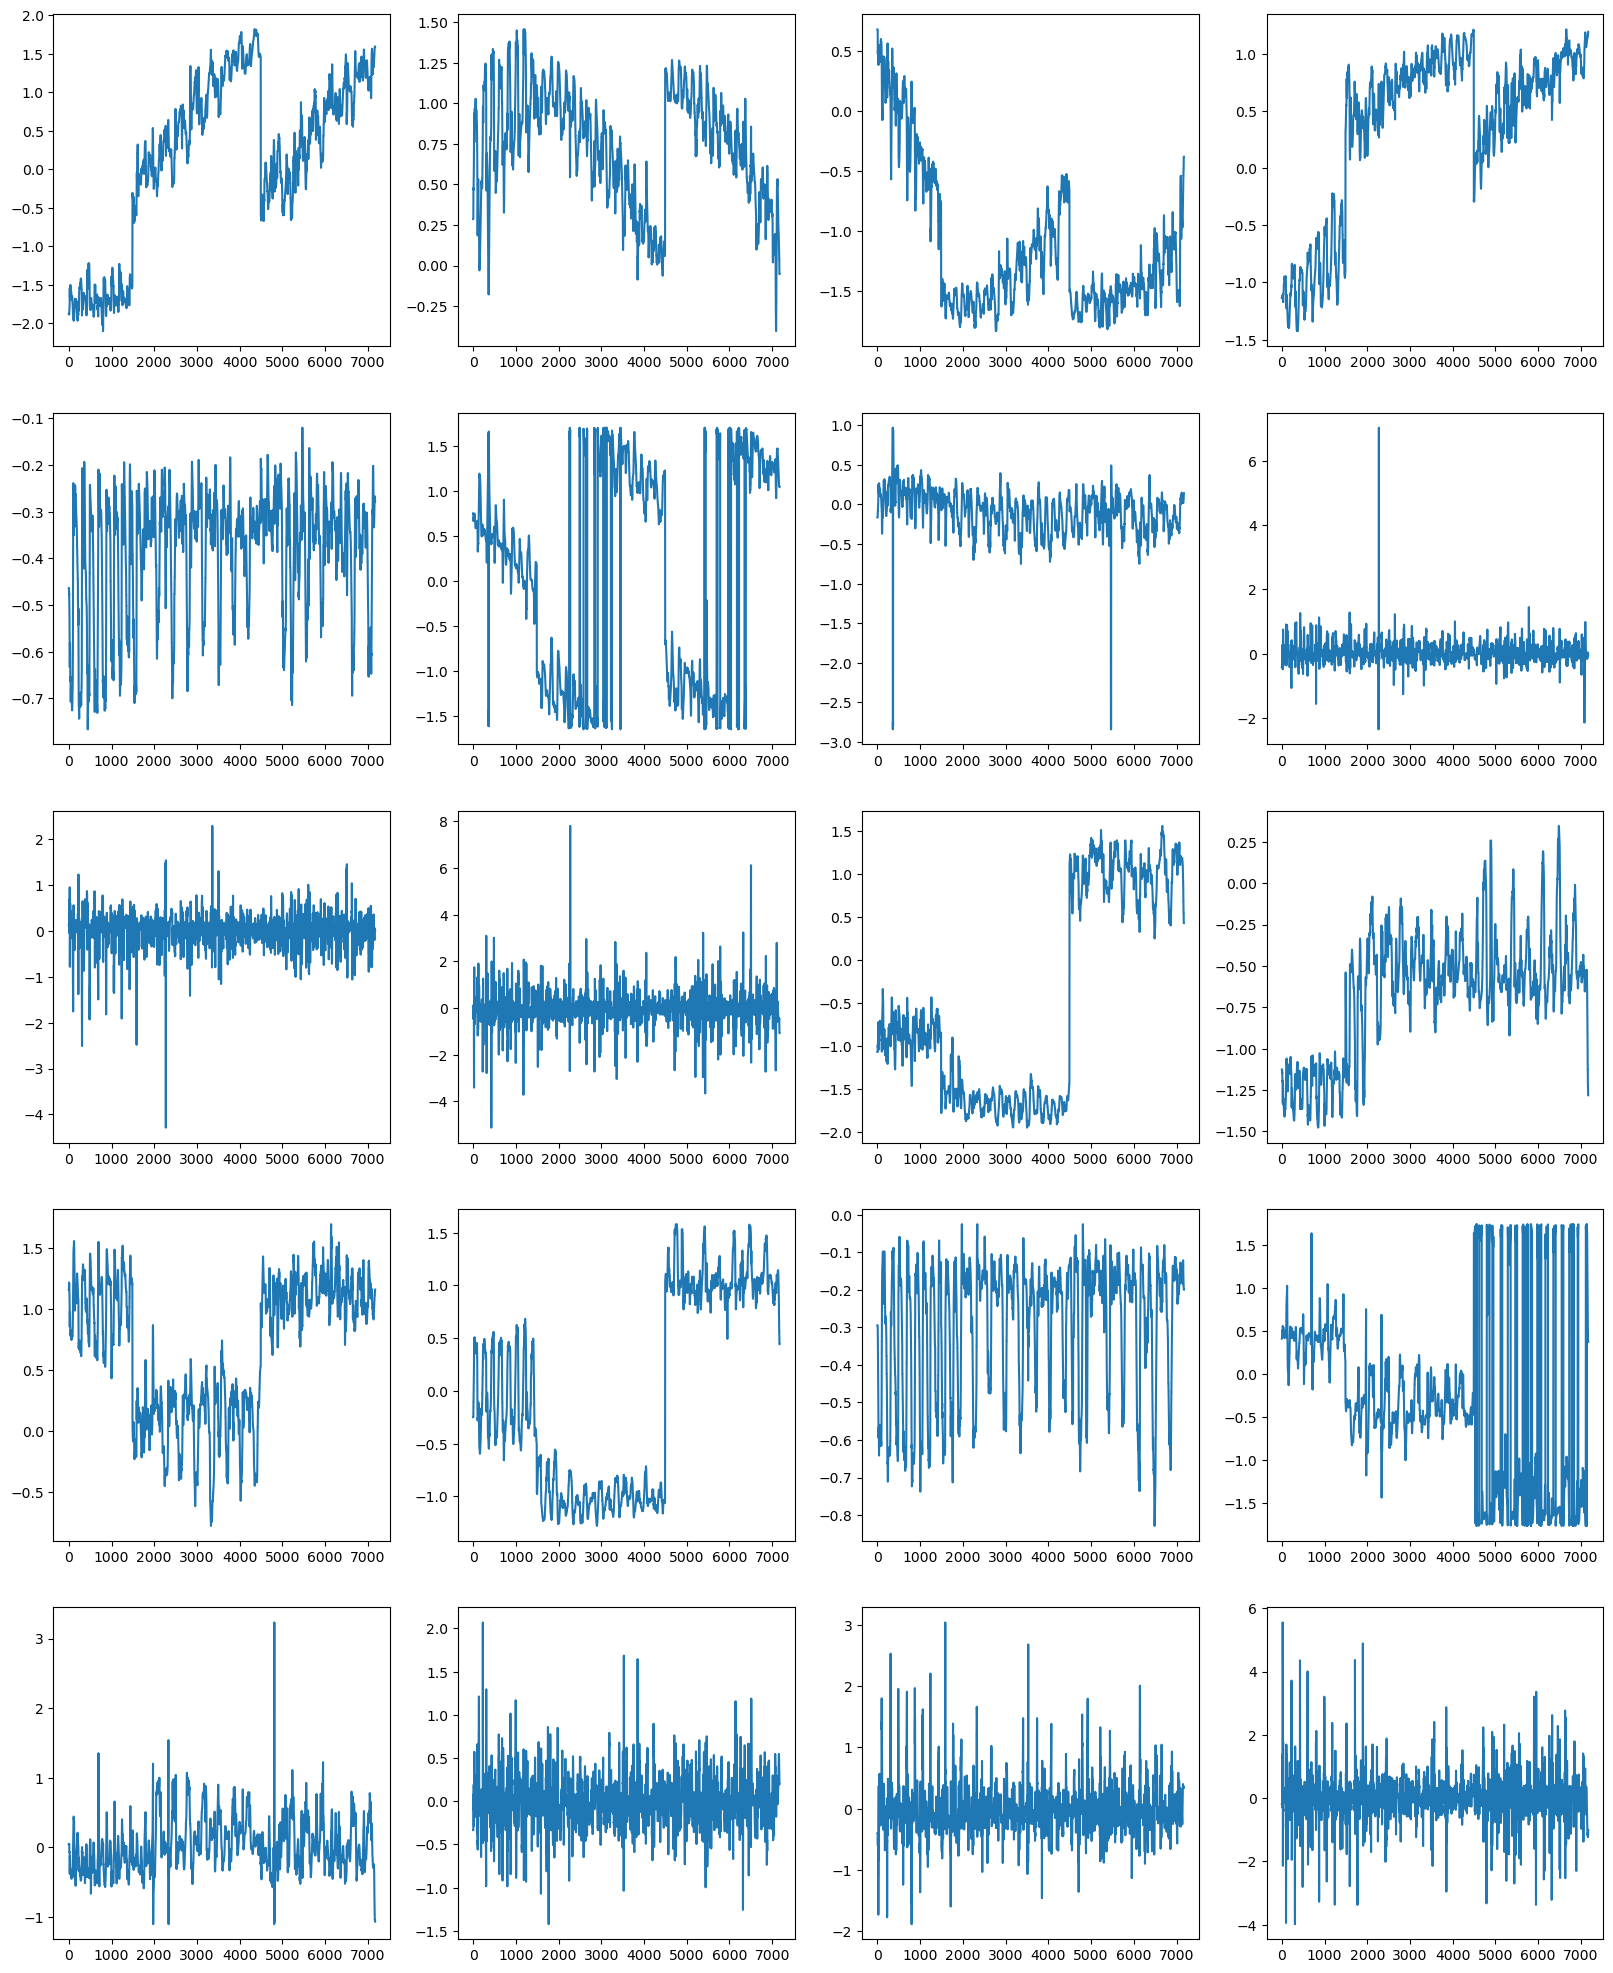

In [6]:
plot_data(x_dset_train[0])

# Generate batches

In [7]:
window_size = 60
stride = 60
batch_size = int(600/window_size)
steps_per_epoch = 10
validation_steps = 10
epochs = 100
pacience = 10

In [8]:
def generate_batches(x_dset, y_dset, window_size=60, stride=60):
    x_batch_aux = []
    y_batch_aux = []
    for i in range(len(x_dset)):
        x_data = x_dset[i]
        y_data = y_dset[i]
        data_shape_0 = len(x_data)
        pointer = 0
        while pointer + window_size < data_shape_0:
            x = x_data[pointer:pointer+window_size,:]
            y = y_data
            pointer += stride
            x_batch_aux.append(x)
            y_batch_aux.append(y)
    return tf.data.Dataset.from_tensor_slices((x_batch_aux, y_batch_aux))

In [9]:
data_train = generate_batches(x_dset_train, y_dset_train, window_size, stride)
data_test = generate_batches(x_dset_test, y_dset_test, window_size, stride)
data_valid = generate_batches(x_dset_valid, y_dset_valid, window_size, stride)

In [10]:
num_train_examples=len(data_train)
num_valid_examples=len(data_valid)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [11]:
train_pipeline = (data_train
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

valid_pipeline = (data_valid
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

test_pipeline = (data_test
                 #.map(preprocess_test)
                 .batch(len(data_test))
                 .prefetch(AUTOTUNE))

# Generate model

In [12]:
def plot_history(history):
    fig = plt.figure(figsize=(13,5))
    gs = grid.GridSpec(1,2)

    ax = plt.subplot(gs[0,0])
    ax.plot(history.history["loss"],label="Train")
    ax.plot(history.history["val_loss"],label="Valid")
    ax.set_title("Loss")

    ax = plt.subplot(gs[0,1])
    ax.plot(history.history["accuracy"],label="Train")
    ax.plot(history.history["val_accuracy"],label="Valid")
    ax.set_title("Accuracy")

    plt.legend()

In [13]:
class MyModel(tf.keras.Model):
    def __init__(self, num_classes=3):
        super(MyModel, self).__init__()
        
        self.lstm_1 = tf.keras.layers.GRU(100, return_sequences=True)#tf.keras.layers.LSTM(100, return_sequences=True)
        self.lstm_2 = tf.keras.layers.GRU(100, go_backwards=True)#tf.keras.layers.LSTM(100, return_sequences=True, go_backwards=True)
        
        self.flat = tf.keras.layers.Flatten()
        
        self.dense_1 = tf.keras.layers.Dense(1000, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(100, activation='relu')
        
        self.out = tf.keras.layers.Dense(num_classes)
        
    def call(self, x):
        
        x = self.lstm_1(x)
        x = self.lstm_2(x)
        
        # x=self.flat(x)
        
        x=self.dense_1(x)
        x=self.dense_2(x)
        
        return self.out(x)

In [14]:
loss = tf.keras.losses.MeanSquaredError()
lr = 0.00005

# Train Model

In [15]:
model = MyModel()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=pacience, restore_best_weights=True)

In [16]:
model.build([batch_size,window_size,20])
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   multiple                  36600     
                                                                 
 gru_1 (GRU)                 multiple                  60600     
                                                                 
 flatten (Flatten)           multiple                  0 (unused)
                                                                 
 dense (Dense)               multiple                  101000    
                                                                 
 dense_1 (Dense)             multiple                  100100    
                                                                 
 dense_2 (Dense)             multiple                  303       
                                                                 
Total params: 298,603
Trainable params: 298,603
Non-traina

In [17]:
trainHist1 = model.fit(x=train_pipeline, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=valid_pipeline, validation_steps=validation_steps, callbacks= [callback])

Epoch 1/100
10/10 [==============================] - 3s 58ms/step - loss: 0.3310 - accuracy: 0.4200 - val_loss: 0.3203 - val_accuracy: 0.3400
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 0.3133 - accuracy: 0.3900 - val_loss: 0.2971 - val_accuracy: 0.3400
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2804 - accuracy: 0.5500 - val_loss: 0.2769 - val_accuracy: 0.3500
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2672 - accuracy: 0.4900 - val_loss: 0.2539 - val_accuracy: 0.4400
Epoch 5/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2451 - accuracy: 0.5000 - val_loss: 0.2360 - val_accuracy: 0.5700
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2297 - accuracy: 0.6000 - val_loss: 0.2310 - val_accuracy: 0.4600
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2136 - accuracy: 0.5700 - val_loss: 0.2100 - val_accuracy: 0.5800
Epoch 

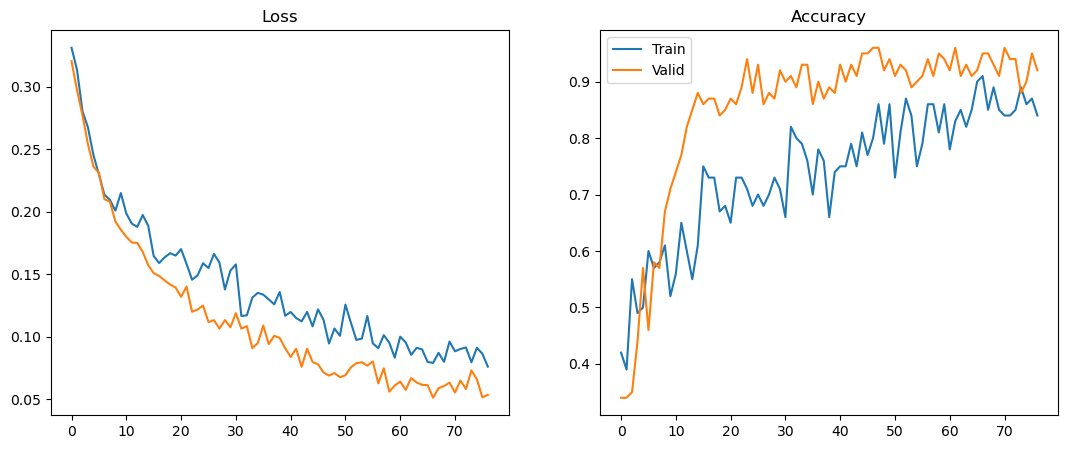

In [18]:
plot_history(trainHist1)

In [19]:
for x,y in test_pipeline:
    y_pred = model.predict(x)
    print(f"Test loss: {loss(y, y_pred)}")
    acc = tf.keras.metrics.Accuracy()
    _ = acc.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
    print(f"Test accuracy: {acc.result().numpy()}")

34/34 [==============================] - 1s 5ms/step
Test loss: 0.1527303010225296
Test accuracy: 0.6810506582260132


#  Window Size experiments

In [20]:
window_size = 100
stride = 100
batch_size = 60

data_train = generate_batches(x_dset_train, y_dset_train, window_size, stride)
data_test = generate_batches(x_dset_test, y_dset_test, window_size, stride)
data_valid = generate_batches(x_dset_valid, y_dset_valid, window_size, stride)

In [21]:
train_pipeline = (data_train
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

valid_pipeline = (data_valid
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

test_pipeline = (data_test
                 #.map(preprocess_test)
                 .batch(len(data_test))
                 .prefetch(AUTOTUNE))

In [22]:
model2 = MyModel()
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=pacience, restore_best_weights=True)

In [23]:
trainHist2 = model2.fit(x=train_pipeline, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=valid_pipeline, validation_steps=validation_steps, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 4s 113ms/step - loss: 0.2846 - accuracy: 0.3883 - val_loss: 0.2660 - val_accuracy: 0.4317
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2518 - accuracy: 0.4283 - val_loss: 0.2325 - val_accuracy: 0.4867
Epoch 3/100
10/10 [==============================] - 0s 27ms/step - loss: 0.2284 - accuracy: 0.4967 - val_loss: 0.2086 - val_accuracy: 0.5167
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.2090 - accuracy: 0.5200 - val_loss: 0.1916 - val_accuracy: 0.5767
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1912 - accuracy: 0.5983 - val_loss: 0.1791 - val_accuracy: 0.6283
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.1861 - accuracy: 0.6417 - val_loss: 0.1689 - val_accuracy: 0.6867
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 0.1784 - accuracy: 0.6267 - val_loss: 0.1612 - val_accuracy: 0.7717
Epoch

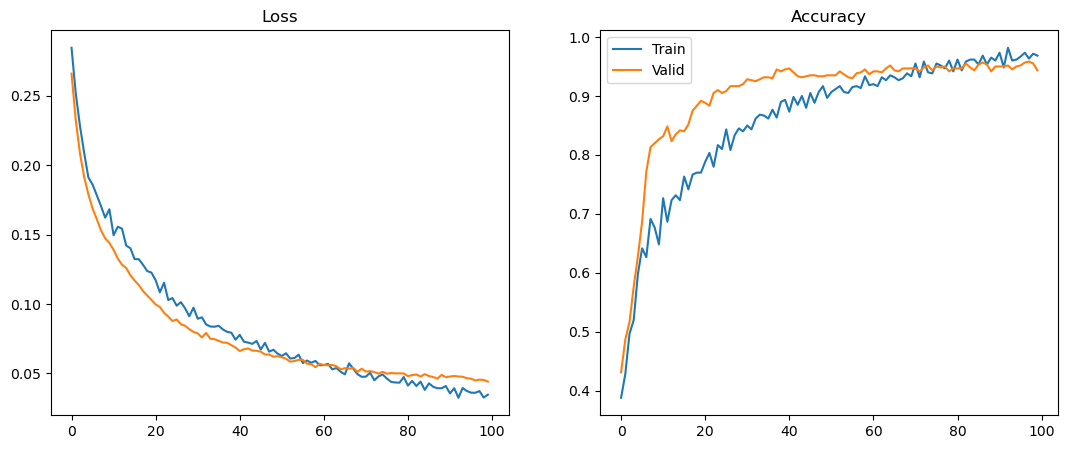

In [24]:
plot_history(trainHist2)

In [25]:
for x,y in test_pipeline:
    y_pred = model2.predict(x)
    print(f"Test loss: {loss(y, y_pred)}")
    acc = tf.keras.metrics.Accuracy()
    _ = acc.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
    print(f"Test accuracy: {acc.result().numpy()}")

20/20 [==============================] - 1s 7ms/step
Test loss: 0.10722124576568604
Test accuracy: 0.7981220483779907


In [26]:
window_size = 60
stride = 60
batch_size = int(600/window_size)

data_train = generate_batches(x_dset_train, y_dset_train, window_size, stride)
data_test = generate_batches(x_dset_test, y_dset_test, window_size, stride)
data_valid = generate_batches(x_dset_valid, y_dset_valid, window_size, stride)

In [27]:
train_pipeline = (data_train
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

valid_pipeline = (data_valid
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

test_pipeline = (data_test
                 #.map(preprocess_test)
                 .batch(len(data_test))
                 .prefetch(AUTOTUNE))

In [28]:
model3 = MyModel()
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=pacience, restore_best_weights=True)

In [29]:
trainHist3 = model3.fit(x=train_pipeline, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=valid_pipeline, validation_steps=validation_steps, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 2s 61ms/step - loss: 0.3074 - accuracy: 0.2900 - val_loss: 0.2966 - val_accuracy: 0.2300
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.2758 - accuracy: 0.4200 - val_loss: 0.2645 - val_accuracy: 0.2600
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.2506 - accuracy: 0.5000 - val_loss: 0.2470 - val_accuracy: 0.3200
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.2277 - accuracy: 0.5800 - val_loss: 0.2365 - val_accuracy: 0.3600
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2209 - accuracy: 0.5400 - val_loss: 0.2223 - val_accuracy: 0.4800
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2087 - accuracy: 0.6200 - val_loss: 0.2129 - val_accuracy: 0.4100
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2007 - accuracy: 0.6400 - val_loss: 0.2033 - val_accuracy: 0.5800
Epoch 

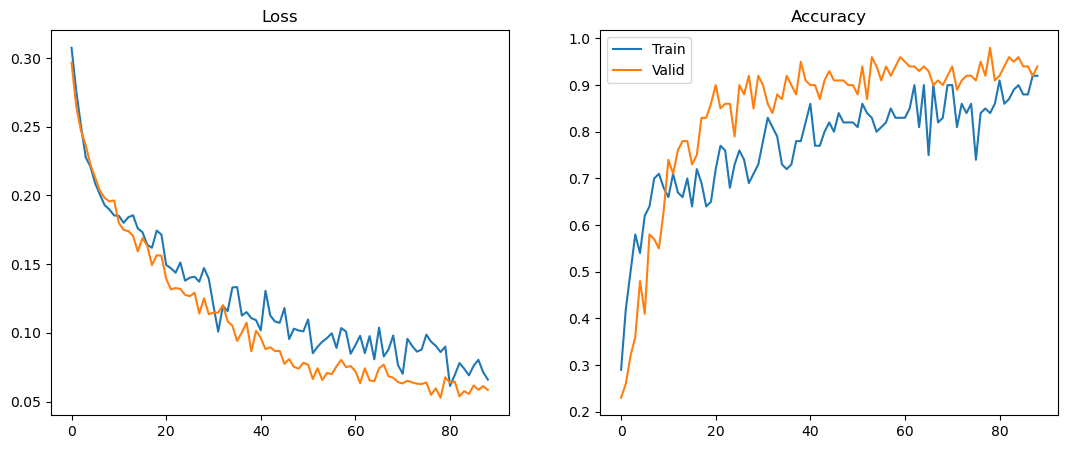

In [30]:
plot_history(trainHist3)

In [31]:
for x,y in test_pipeline:
    y_pred = model3.predict(x)
    print(f"Test loss: {loss(y, y_pred)}")
    acc = tf.keras.metrics.Accuracy()
    _ = acc.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
    print(f"Test accuracy: {acc.result().numpy()}")

34/34 [==============================] - 1s 4ms/step
Test loss: 0.1384919136762619
Test accuracy: 0.7148217558860779


In [32]:
window_size = 30
stride = 30
batch_size = 60

data_train = generate_batches(x_dset_train, y_dset_train, window_size, stride)
data_test = generate_batches(x_dset_test, y_dset_test, window_size, stride)
data_valid = generate_batches(x_dset_valid, y_dset_valid, window_size, stride)

In [33]:
train_pipeline = (data_train
                  .shuffle(1000)
                  .repeat()#
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

valid_pipeline = (data_valid
                  .shuffle(1000)
                  .repeat()
                  #.map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

test_pipeline = (data_test
                 #.map(preprocess_test)
                 .batch(len(data_test))
                 .prefetch(AUTOTUNE))

In [34]:
model4 = MyModel()
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=pacience, restore_best_weights=True)

In [35]:
trainHist4 = model4.fit(x=train_pipeline, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=valid_pipeline, validation_steps=validation_steps, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 2s 60ms/step - loss: 0.2991 - accuracy: 0.4133 - val_loss: 0.2803 - val_accuracy: 0.3567
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 0.2689 - accuracy: 0.5217 - val_loss: 0.2506 - val_accuracy: 0.4567
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2504 - accuracy: 0.4650 - val_loss: 0.2290 - val_accuracy: 0.5567
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 0.2288 - accuracy: 0.5650 - val_loss: 0.2130 - val_accuracy: 0.5867
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 0.2102 - accuracy: 0.5767 - val_loss: 0.2000 - val_accuracy: 0.6233
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1982 - accuracy: 0.5633 - val_loss: 0.1852 - val_accuracy: 0.6633
Epoch 7/100
10/10 [==============================] - 0s 10ms/step - loss: 0.1960 - accuracy: 0.5383 - val_loss: 0.1742 - val_accuracy: 0.6433
Epoch 8

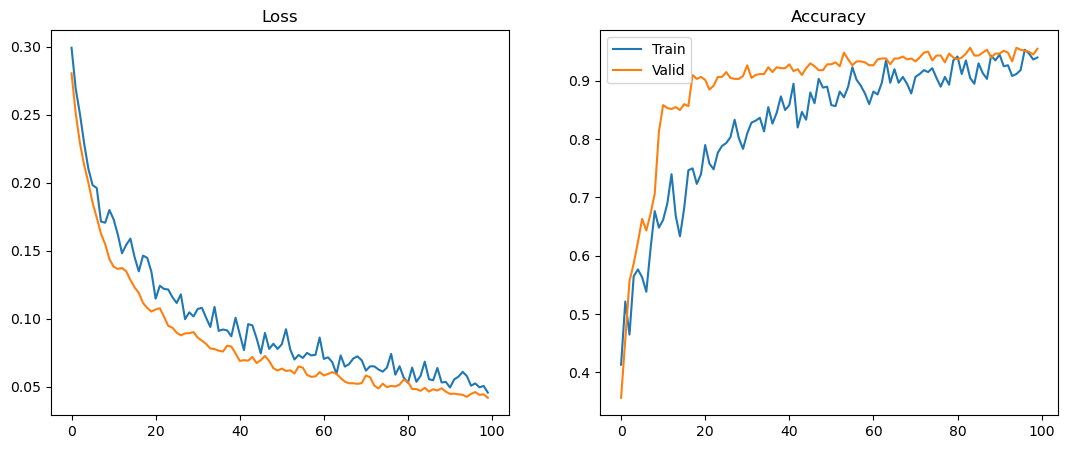

In [36]:
plot_history(trainHist4)

In [37]:
for x,y in test_pipeline:
    y_pred = model4.predict(x)
    print(f"Test loss: {loss(y, y_pred)}")
    acc = tf.keras.metrics.Accuracy()
    _ = acc.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
    print(f"Test accuracy: {acc.result().numpy()}")

67/67 [==============================] - 1s 3ms/step
Test loss: 0.10988465696573257
Test accuracy: 0.7835437059402466


### Conclusions

During the experiments the window size and stride always have the same value, but we change that value between 30, 60 and 100. The results are:

| Window Size | Loss | Accuracy |
| --- | --- | --- |
| 30 | 0.10988 | 0.78354 |
| 60 | 0.13849 | 0.71482 |
| 100 | **0.10722** | **0.79812** |


From the experiments it seems the bigger window size allows to higher performance, i.e, the more data points the easier it is to classify. However, for window size 60 the performance drops. This could suggest that the model is not well trained or that the hyperparameters are not optimum. More in depth analysis would be needed to find the root of this issue.

# Data augmentation

The data is from sensors of the legs and arms of a person. Therefore changing the left and right arms/legs sensors with a flip on the horizontal axis acordingly should be a good data augmentation.
Unfortunatelly, there doesn't seem to be any information on what the different chanels represent in the github https://github.com/RafaelDrumond/PeekDB or at least I wasn't able to find it.

Some of the augmentations implemented come from [Time Series Data Augmentation for Deep Learning: A Survey](https://arxiv.org/pdf/2002.12478.pdf).

In [45]:
def preprocess_train(x,y):
    #Cropping
    crop_prob = 0.05
    crop_length = 10
    doCrop = random.random() < crop_prob
    if doCrop:
        pos = random.randint(0,x.shape[0]-crop_length-1)
        channel = random.randint(0,x.shape[1]-1)
        x[pos:pos+crop_length,channel] = x[pos,channel]
    #Noise addition
    eps = 0.01
    noise = eps*tf.random.normal(x.shape, dtype='float64')
    x = x + noise
    #Return augmented data
    return x, y

In [46]:
window_size = 100
stride = 100
batch_size = 60

data_train = generate_batches(x_dset_train, y_dset_train, window_size, stride)
data_test = generate_batches(x_dset_test, y_dset_test, window_size, stride)
data_valid = generate_batches(x_dset_valid, y_dset_valid, window_size, stride)

In [47]:
train_pipeline = (data_train
                  .shuffle(1000)
                  .repeat()
                  .map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

valid_pipeline = (data_valid
                  .shuffle(1000)
                  .repeat()
                  .map(preprocess_train)
                  .batch(batch_size)
                  .prefetch(AUTOTUNE))

test_pipeline = (data_test
                 .batch(len(data_test))
                 .prefetch(AUTOTUNE))

In [48]:
model5 = MyModel()
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(patience=pacience, restore_best_weights=True)

In [49]:
trainHist5 = model5.fit(x=train_pipeline, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=valid_pipeline, validation_steps=validation_steps, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 2s 85ms/step - loss: 0.3300 - accuracy: 0.4650 - val_loss: 0.3142 - val_accuracy: 0.5183
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - loss: 0.2952 - accuracy: 0.5033 - val_loss: 0.2781 - val_accuracy: 0.5700
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - loss: 0.2581 - accuracy: 0.6067 - val_loss: 0.2492 - val_accuracy: 0.6133
Epoch 4/100
10/10 [==============================] - 0s 27ms/step - loss: 0.2311 - accuracy: 0.6283 - val_loss: 0.2257 - val_accuracy: 0.6250
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 0.2162 - accuracy: 0.5817 - val_loss: 0.2052 - val_accuracy: 0.6533
Epoch 6/100
10/10 [==============================] - 0s 25ms/step - loss: 0.1987 - accuracy: 0.6383 - val_loss: 0.1906 - val_accuracy: 0.6967
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 0.1824 - accuracy: 0.6433 - val_loss: 0.1804 - val_accuracy: 0.7417
Epoch 

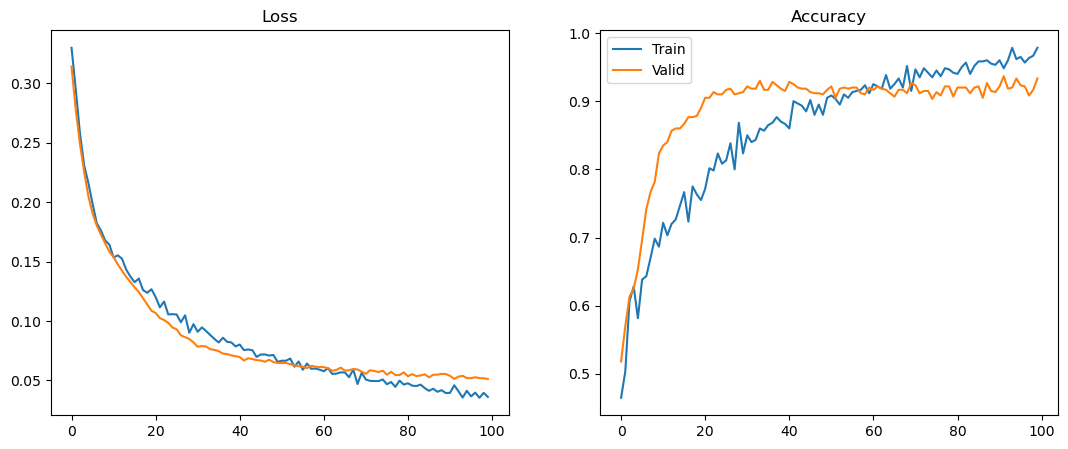

In [50]:
plot_history(trainHist5)

In [51]:
for x,y in test_pipeline:
    y_pred = model5.predict(x)
    print(f"Test loss: {loss(y, y_pred)}")
    acc = tf.keras.metrics.Accuracy()
    _ = acc.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
    print(f"Test accuracy: {acc.result().numpy()}")

20/20 [==============================] - 0s 5ms/step
Test loss: 0.10589732974767685
Test accuracy: 0.7902973294258118


### Conclusions

The results of applying the augmentations are:

| Augmentation | Loss | Accuracy |
| --- | --- | --- |
| Yes | **0.10589** | 0.79029 |
| No | 0.10722 | **0.79812** |


These results are inconclusive. In general, applying data augmentation should lead to better model performance. Nevertheless, wrong hyperparameter tunning in the augmentation techniques such as the amount of noise added or the probability and length or the crop could deteriorate the model performance. More experiments would be needed to improve the data augmentation selection of hyperparameters.